In [1]:
import numpy as np
import tensorflow as tf

%pylab inline

import mccd
from astropy.io import fits
from mccd.denoising.learnlets.learnlet_model import Learnlet


Populating the interactive namespace from numpy and matplotlib


In [2]:

!ls -lah /n05data/ayed/outputs/eigenpsfs/


total 15G
drwxrwxr-x 2 ayed ayed  109 Jul 19  2021 .
drwxrwxr-x 5 ayed ayed 4.0K Jul 18  2021 ..
-rw-rw-r-- 1 ayed ayed 5.2G Jul 19  2021 dataset_eigenpsfs.fits
-rw-rw-r-- 1 ayed ayed 391M Jul 19  2021 global_eigenpsfs.fits
-rw-rw-r-- 1 ayed ayed 4.8G Jul 19  2021 local_eigenpsfs.fits


In [3]:
# Load dataset

# global_dataset_path = '/n05data/ayed/outputs/eigenpsfs/global_eigenpsfs.fits'
# dataset = fits.open(global_dataset_path)
# dataset[1].columns
# images = dataset[1].data['VIGNETS_NOISELESS']


In [163]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from mccd.denoising.learnlets.learnlet_model import Learnlet
from mccd.denoising.evaluate import keras_psnr, center_keras_psnr
from mccd.denoising.preprocessing import eigenPSF_data_gen


In [164]:

# Paths
eigenpsf_dataset_path = '/n05data/ayed/outputs/eigenpsfs/global_eigenpsfs.fits'
base_save_path = '/n05data/tliaudat/new_deepmccd/reproduce_aziz_results/testing_networks/'
checkpoint_path = base_save_path + 'cp_256.h5'


In [165]:
img = fits.open(eigenpsf_dataset_path)
img = img[1].data['VIGNETS_NOISELESS']


In [166]:
size_train = np.floor(len(img)*0.90)
training, test = img[:int(size_train),:,:], img[int(size_train):,:,:]

batch_size = 16


In [167]:


training_ds = eigenPSF_data_gen(data=training,
                    snr_range=[0.1,100],
                    img_shape=(51, 51),
                    batch_size=batch_size,
                    n_shuffle=50)

test_ds = eigenPSF_data_gen(data=test,
                 snr_range=[0.1,100],
                 img_shape=(51, 51),
                 batch_size=1)


In [236]:

run_params = {
    'denoising_activation': 'dynamic_soft_thresholding',
    'learnlet_analysis_kwargs':{
        'n_tiling': 256,
        'mixing_details': False,
        'skip_connection': True,
    },
    'learnlet_synthesis_kwargs': {
        'res': True,
    },
    'threshold_kwargs':{
        'noise_std_norm': True,
    },
#     'wav_type': 'bior',
    'n_scales': 5,
    'n_reweights_learn': 1,
    'clip': False,
}


In [237]:

model=Learnlet(**run_params)
n_epochs = 2
steps = int(size_train/batch_size)
print(steps)

1106


In [238]:

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='mse',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    save_freq='epoch',
    options=None
)


In [239]:

def l_rate_schedule(epoch):
    return max(1e-3 / 2**(epoch//25), 1e-5)

lr_cback = tf.keras.callbacks.LearningRateScheduler(l_rate_schedule)


In [242]:
use_lr_scheduler = False

if use_lr_scheduler:
    models_callbacks = [cp_callback, lr_cback]
else:
    models_callbacks = [cp_callback]


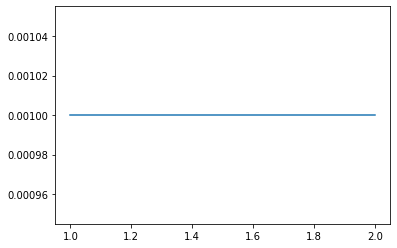

In [243]:

epoch_seq = np.arange(n_epochs)+1
lr_seq = np.array([l_rate_schedule(epoch) for epoch in epoch_seq])

plt.figure()
plt.plot(epoch_seq, lr_seq)
plt.show()


In [244]:
model.compile(optimizer=Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mse', keras_psnr, center_keras_psnr],
)


In [245]:

history = model.fit(
    training_ds,
    validation_data=test_ds,
    steps_per_epoch=steps,
    epochs=n_epochs,
    validation_steps=1,
    callbacks=models_callbacks,
    shuffle=False,
    verbose=1,
)


Epoch 1/2
1106/1106 [==============================] - 43s 37ms/step - loss: 0.0020 - mse: 0.0020 - keras_psnr: 45.3886 - center_keras_psnr: 44.8440 - val_loss: 3.7620e-05 - val_mse: 3.7620e-05 - val_keras_psnr: 44.2458 - val_center_keras_psnr: 39.9655

Epoch 00001: mse improved from inf to 0.00039, saving model to /n05data/tliaudat/new_deepmccd/reproduce_aziz_results/testing_networks/cp_256.h5
Epoch 2/2
1106/1106 [==============================] - 41s 37ms/step - loss: 5.8643e-05 - mse: 5.8643e-05 - keras_psnr: 51.7537 - center_keras_psnr: 52.2049 - val_loss: 3.6136e-06 - val_mse: 3.6136e-06 - val_keras_psnr: 54.4206 - val_center_keras_psnr: 50.9910

Epoch 00002: mse improved from 0.00039 to 0.00008, saving model to /n05data/tliaudat/new_deepmccd/reproduce_aziz_results/testing_networks/cp_256.h5


In [182]:
print(model.summary(line_length=114))

Model: "learnlet_23"
__________________________________________________________________________________________________________________
Layer (type)                                       Output Shape                                 Param #           
learnlet_analysis_23 (LearnletAnalysis)            multiple                                     32025             
__________________________________________________________________________________________________________________
scales_threshold_23 (ScalesThreshold)              multiple                                     1290              
__________________________________________________________________________________________________________________
learnlet_synthesis_23 (LearnletSynthesis)          multiple                                     32125             
Total params: 65,440
Trainable params: 64,130
Non-trainable params: 1,310
____________________________________________________________________________________________________

In [215]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [211]:

np.save(base_save_path + 'history_file.npy', history.history, allow_pickle=True)


# Checkout the denoising



In [183]:

run_params = {
    'denoising_activation': 'dynamic_soft_thresholding',
    'learnlet_analysis_kwargs':{
        'n_tiling': 256,
        'mixing_details': False,
        'skip_connection': True,
    },
    'learnlet_synthesis_kwargs': {
        'res': True,
    },
    'threshold_kwargs':{
        'noise_std_norm': True,
    },
#     'wav_type': 'bior',
    'n_scales': 5,
    'n_reweights_learn': 1,
    'clip': False,
}

im_shape = (51,51)
im_val = tf.convert_to_tensor(np.random.rand(2, im_shape[0], im_shape[1], 1))
std_val = tf.convert_to_tensor(np.random.rand(2))

new_learnlets = Learnlet(**run_params)
new_learnlets.compile(
    optimizer = tf.keras.optimizers.Adam(lr=1e-6),
    loss='mse',
)
new_learnlets.fit(
    (im_val, std_val),
    im_val,
    validation_data = ((im_val, std_val), im_val),
    steps_per_epoch = 1,
    epochs = 1,
    batch_size=12,
)

new_learnlets.load_weights(checkpoint_path)


1/1 [==============================] - 2s 2s/step - loss: 0.1110 - val_loss: 0.1197


In [184]:

old_weights_path = '/home/tliaudat/github/aziz_repos/deep_mccd/mccd/saving_learnlets/cp.h5'

old_learnlets = Learnlet(**run_params)
old_learnlets.compile(
    optimizer = tf.keras.optimizers.Adam(lr=1e-6),
    loss='mse',
)
old_learnlets.fit(
    (im_val, std_val),
    im_val,
    validation_data = ((im_val, std_val), im_val),
    steps_per_epoch = 1,
    epochs = 1,
    batch_size=12,
)
old_learnlets.load_weights(old_weights_path)



1/1 [==============================] - 2s 2s/step - loss: 0.1111 - val_loss: 0.1210


## Run some examples

In [185]:
class ProxLearnlets:
    r"""Apply Learnlets denoising.

    Parameters
    ----------
    model: str
        Which denoising algorithm to use.
        We couldn't save the whole architecture of the model, thus we use the weights of the model. However, this requires a
        first step of initialization that we didn't need for the U-Nets.

    """

    def __init__(self, weight_path=None, items=None):
        r"""Initialize class attributes."""
        self.im_shape = (51,51)

        # Calculate window function for estimating the noise
        # We couldn't use Galsim to estimate the moments, so we chose to work with the real center of the image (25.5,25.5)
        # instead of using the real centroid. Also, we use 13 instead of 5*obs_sigma, so that we are sure to cut all the flux
        # from the star
        self.noise_window = np.ones(self.im_shape, dtype=bool)
        for coord_x in range(self.im_shape[0]):
            for coord_y in range(self.im_shape[1]):
                if np.sqrt((coord_x - 25.5)**2 + (coord_y - 25.5)**2) <= 13 :
                    self.noise_window[coord_x, coord_y] = False

        im_val = tf.convert_to_tensor(np.random.rand(2, self.im_shape[0], self.im_shape[1], 1))
        std_val = tf.convert_to_tensor(np.random.rand(2))
        run_params = {
            'denoising_activation': 'dynamic_soft_thresholding',
            'learnlet_analysis_kwargs':{
                'n_tiling': 256,
                'mixing_details': False,
                'skip_connection': True,
            },
            'learnlet_synthesis_kwargs': {
                'res': True,
            },
            'threshold_kwargs':{
                'noise_std_norm': True,
            },
        #     'wav_type': 'bior',
            'n_scales': 5,
            'n_reweights_learn': 1,
            'clip': False,
        }
        learnlets = Learnlet(**run_params)
        learnlets.compile(
            optimizer=Adam(lr=1e-6),
            loss='mse',
        )
        learnlets.fit(
            (im_val, std_val),
            im_val,
            validation_data = ((im_val, std_val), im_val),
            steps_per_epoch = 1,
            epochs = 1,
            batch_size=12,
        )
        learnlets.load_weights(weight_path)
        self.model = learnlets
        self.noise = None

    def mad(self, x):
        r"""Compute an estimation of the standard deviation
        of a Gaussian distribution using the robust
        MAD (Median Absolute Deviation) estimator."""
        return 1.4826*np.median(np.abs(x - np.median(x)))

    def noise_estimator(self, image):
        r"""Estimate the noise level of the image."""
        # Calculate noise std dev
        return self.mad(image[self.noise_window])

    @staticmethod
    def convert_and_pad(image):
        r""" Convert images to tensorflow's tensor and add an extra 4th dimension."""
        return tf.expand_dims(tf.convert_to_tensor(image), axis=3)

    @staticmethod
    def crop_and_convert(image):
        r"""Convert to numpy array and remove the 4th dimension."""
        return image.numpy()[:,:,:,0]

    @staticmethod
    def scale_img(image):
        r"""Scale image to [-0.5, 0.5]. 
        
        Return the scaled image.
        """
        img_max = np.max(image)
        img_min = np.min(image)

        image -= img_min
        image /= (img_max - img_min)
        image -= 0.5

        return image

    @staticmethod
    def rescale_img(image, new_max, new_min):
        r"""Rescale the image from [-0.5, 0.5] to [min, max]."""
        image += 0.5
        image *= (new_max - new_min)
        image += new_min
        return image

    def op(self, image, **kwargs):
        r"""Apply Learnlets denoising."""
        # image = utils.reg_format(image)
        # Transform all eigenPSFs into positive (avoid sign indetermination)
        multiple = np.array([np.sum(im)>0 for im in image]) * 2. - 1.
        image *= multiple.reshape((-1, 1, 1))
        # Scale 
        img_maxs = np.amax(image, axis=(1,2))
        img_mins = np.amin(image, axis=(1,2))
        image = np.array([self.scale_img(im) for im in image])
         # Calculate noise
        self.noise = np.array([self.noise_estimator(im) for im in image])
        self.noise = tf.reshape(tf.convert_to_tensor(self.noise), [len(image), 1])
        # Convert to tensorflow and expand 4th dimension
        image = self.convert_and_pad(image)
        # Denoise
        image = self.model.predict((image, self.noise))
        # Rescale the images to the original max and min values
        image = np.array([
            self.rescale_img(im, _max, _min) 
            for im, _max, _min in zip(image, img_maxs, img_mins)
        ])
        # Retransform eigenPSF into their original sign
        image = tf.math.multiply(multiple.reshape((-1, 1, 1, 1)), image)
        return self.crop_and_convert(image)
        # return utils.rca_format(self.crop_and_convert(image))

    def cost(self, x, y):
        r"""Return cost."""
        return 0
    


In [186]:

old_ProxLearnlets = ProxLearnlets(old_weights_path)
new_ProxLearnlets = ProxLearnlets(checkpoint_path)


1/1 [==============================] - 2s 2s/step - loss: 0.1127 - val_loss: 0.1199


In [193]:


desired_SNR = 5
image_size = 51

short_eigenPSF = test

sigma_noise = np.array([np.sqrt((np.sum(img ** 2) / (desired_SNR * image_size ** 2))) for img in short_eigenPSF])

noisy_test = np.array([im + np.random.randn(image_size, image_size)*sig for im, sig in zip(short_eigenPSF, sigma_noise)])



In [194]:
# Test the noise estimation
est_noise = np.array([old_ProxLearnlets.noise_estimator(im) for im in noisy_test])

print(sigma_noise[:10])
print(est_noise[:10])
print(sigma_noise[:10]- est_noise[:10])


[0.0001813  0.00035655 0.00046938 0.00023141 0.00034606 0.00149625
 0.00025864 0.00341844 0.0002483  0.00054299]
[0.00019637 0.00034308 0.00045816 0.00024015 0.00034251 0.00151596
 0.00026181 0.00342688 0.00025338 0.0005559 ]
[-1.50641048e-05  1.34710258e-05  1.12235244e-05 -8.74073335e-06
  3.55642748e-06 -1.97173250e-05 -3.16985655e-06 -8.44258807e-06
 -5.08100720e-06 -1.29062148e-05]


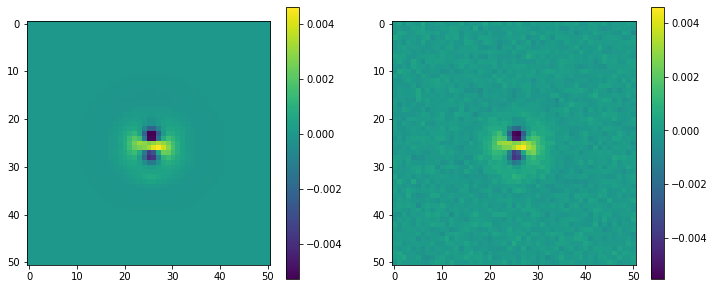

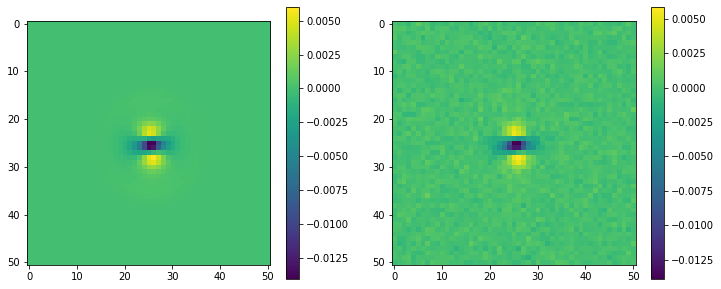

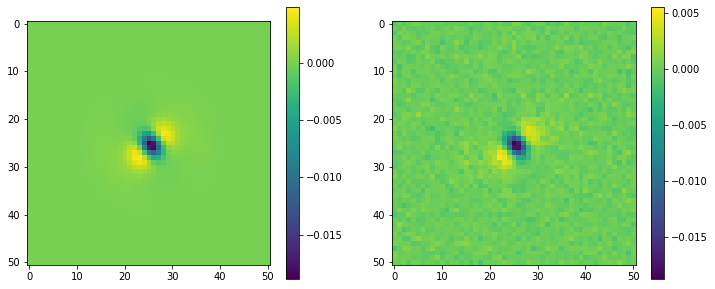

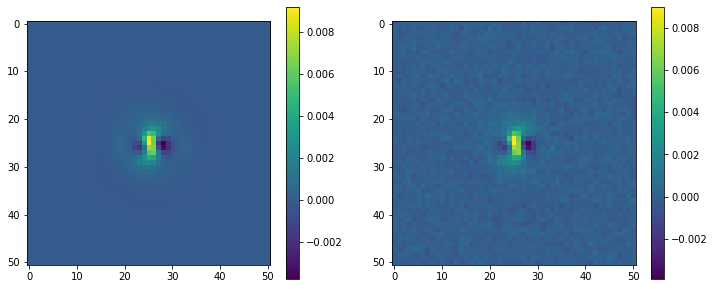

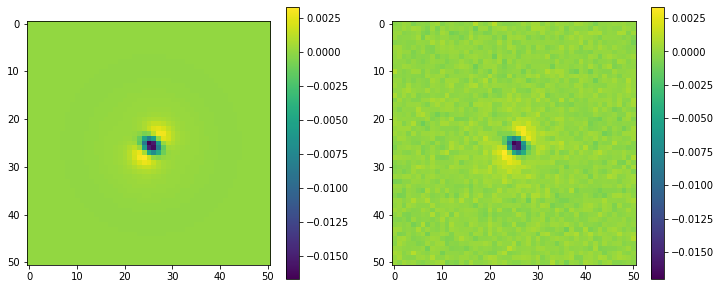

In [195]:

for it in range(5):
    figure(figsize=(12,5))
    subplot(121)
    imshow(short_eigenPSF[it,:,:]);colorbar()
    
    subplot(122)
    imshow(noisy_test[it,:,:]);colorbar()
    show()


In [196]:
# Denoise with old learnlets
denoised_old = old_ProxLearnlets.op(np.copy(noisy_test))


In [197]:

# Denoise with new learnlets
denoised_new = new_ProxLearnlets.op(np.copy(noisy_test))



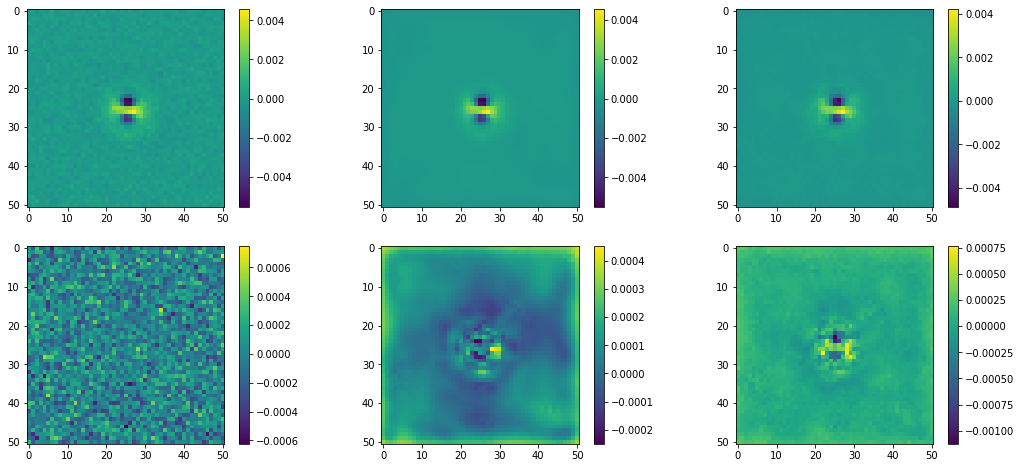

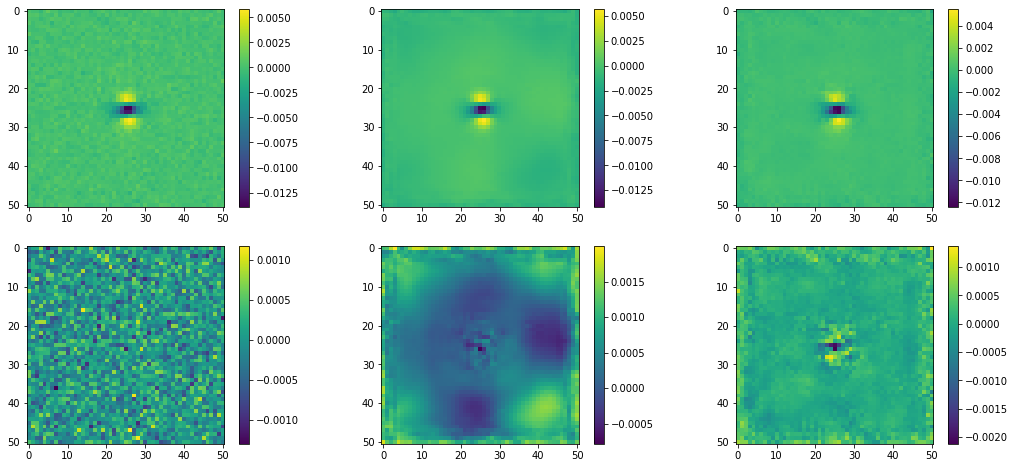

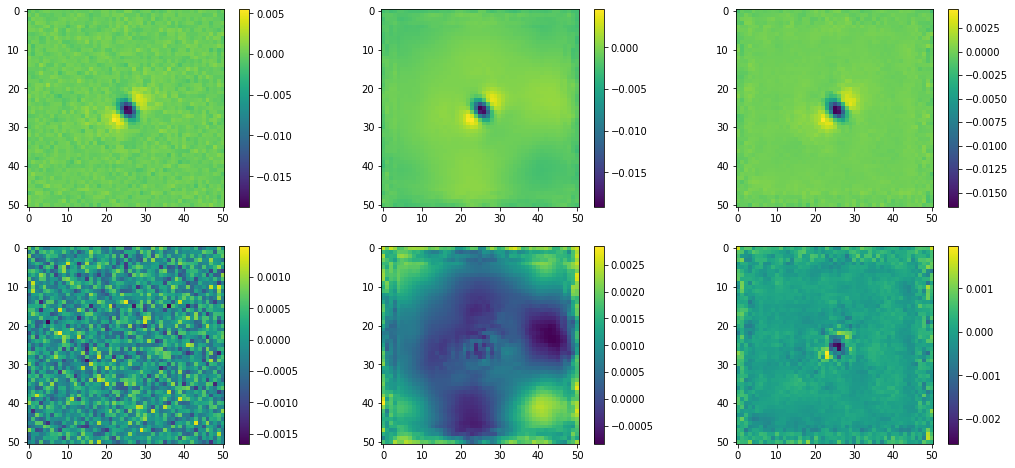

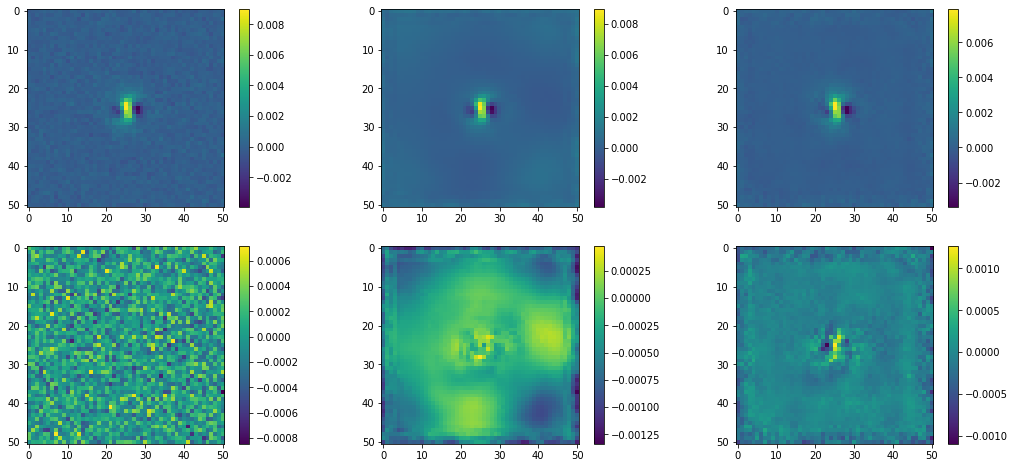

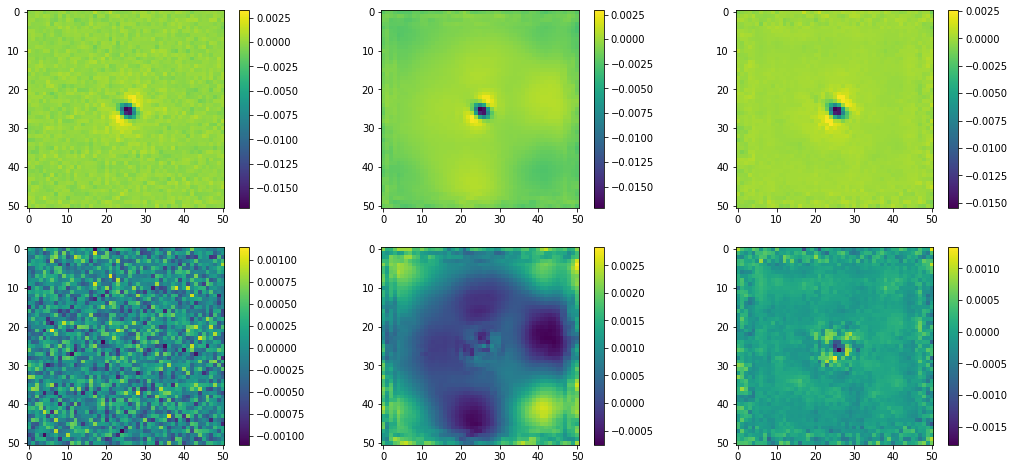

In [198]:

for it in range(5):
    figure(figsize=(18,8))
    subplot(231)
    imshow(noisy_test[it,:,:]);colorbar()
    
    subplot(232)
    imshow(denoised_old[it,:,:]);colorbar()
    
    subplot(233)
    imshow(denoised_new[it,:,:]);colorbar()
 
    subplot(234)
    imshow(short_eigenPSF[it,:,:] - noisy_test[it,:,:]);colorbar()
    
    subplot(235)
    imshow(short_eigenPSF[it,:,:] - denoised_old[it,:,:]);colorbar()
    
    subplot(236)
    imshow(short_eigenPSF[it,:,:] - denoised_new[it,:,:]);colorbar()
    
    
    show()

